# __Data Mining 27 - Processing__

### Features that are going to be used in the model (based on RFM model + other features)
- __Recency__ -> How recently has a customer used the service:
    - last time a customer went to the gym: **'n_recency'**
<br><br>    
- __Frequency__ -> How often has a customer used the service, variables that are going to be used:

    - going to the gym: **'n_frequenciesWeek'**
    - going to a class: **'n_classesWeek'**
<br><br>
- __Monetary value__ -> How much money has a customer spent or can spend:

    - average spend per month: **'n_spendMonth'**
<br><br>
- __Loyalty__ -> How long has a customer been a customer:
    - time as a customer: **'n_timeAsCustomer'**

In [48]:
import pandas as pd
import numpy as np 
import ydata_profiling
import matplotlib.pyplot as plt
import seaborn as sns


# Scalers 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Imputers
from sklearn.impute import KNNImputer

In [49]:
data = pd.read_csv('../Datasets/XYZ_sports_dataset.csv', sep=';')
data_original = data.copy()

## __1. First analysis and selection with pandas profiling__

##### 0. Profiling

In [50]:
# Lets make a profiling report
#profile = pandas_profiling.ProfileReport(data)
#profile.to_file(outputfile="XYZ_sports_dataset.html")

##### 1. Constant features
- DanceActivities
- NatureActivities

In [51]:
data = data.drop(['DanceActivities', 'NatureActivities'], axis=1)

##### 2. Quasi-constant features (highly inbalanced)
- OtherActivities (98.0%) - 28 values out of 14900 are different
- AtheleticsActivities (93.7%) - 110 values out of 14900 are different
- NumberOfReferences (92.4%) - 98% are zero 

Using a threshold of 90%. Variables not listed have a lower percentage of imbalance.

In [52]:
dropped = data[['OtherActivities', 'NumberOfReferences', 'AthleticsActivities']]
data = data.drop(['OtherActivities', 'NumberOfReferences', 'AthleticsActivities'], axis=1)

##### 3. Uniform features that provide no information 
Since all values are unique and they dont provide any kind of ordinal information, they are removed.
- ID

In [53]:
data = data.drop(['ID'], axis=1)

##### 4. Get rid of duplicates 

In [54]:
# Search and delete duplicates
print('Number of duplicates:', data.duplicated().sum())
data = data.drop_duplicates()

Number of duplicates: 1


## __2. Feature name change for better understanding__
Like this, I will be able to access them more easily and understand what they are.
1. Binary will start with a b
2. Numerical will start with n
3. Date will start with d

In [55]:
data.columns = ['n_age', 'b_gender', 'n_income', 'd_enrollmentStart', 'd_enrollmentFinish', 'd_lastPeriodStart', 'd_lastPeriodFinish', 'd_lastVisit', 'n_daysWithoutFrequency', 'n_lifetimeValue',
                'b_useByTime', 'b_waterActivities', 'b_fitnessActivities', 'b_teamActivities', 'b_racketActivities', 'b_combatActivities', 'b_specialActivities', 'n_frequencies',
                'n_attendedClasses', 'n_allowedWeeklyVisits', 'n_allowedVisits', 'n_realVisits', 'n_renewals', 'b_hasReferences', 'b_dropout']

data['b_gender'] = data['b_gender'].map({'Male' : 0, 'Female' : 1})

Lets recheck the imbalances in the binary and numerical features <br><br>
__1. Binary features__

In [56]:
binary_features = [col for col in data.columns if col.startswith('b_')]

balance = {}
for feature in binary_features:
    value_counts = data.value_counts(feature)
    balance[feature] = 100* round(value_counts.min() / value_counts.max(),3)

balance = pd.DataFrame.from_dict(balance, orient='index', columns=['balance'])
balance = balance.sort_values(by='balance', ascending=False)
balance

balance
b_fitnessActivities     73.6
b_gender                67.3
b_waterActivities       42.1
b_dropout               24.9
b_combatActivities      12.1
b_teamActivities         5.9
b_useByTime              4.9
b_specialActivities      2.7
b_racketActivities       2.4
b_hasReferences          2.0

Segmenting customers in such smalls groups is not the best idea (2% of the data). Lets set the threshold to 3% and remove the features that have less than that. 
We will, of course, keep a backup of the dropped features, because they might be useful for feature engineering:
- Joining the very unlikely activities into one feature might prove useful, but that's an idea for later

In [57]:
# Remove features with balance < 3%
remove = balance[balance['balance'] < 3].index.to_list()
dropped = pd.concat([data[remove], dropped], axis=1)
data = data.drop(remove, axis=1)


__2. Numerical Features__

In [58]:
numerical_features = [col for col in data.columns if col.startswith('n_')]

In [59]:
data[numerical_features].describe().T

count         mean          std   min      25%  \
n_age                   14941.0    26.016732    14.156592  0.00    19.00   
n_income                14446.0  2230.970511  1566.471988  0.00  1470.00   
n_daysWithoutFrequency  14941.0    81.227629   144.204026  0.00    13.00   
n_lifetimeValue         14941.0   302.577212   364.326932  0.00    83.60   
n_frequencies           14915.0    40.122293    65.468305  1.00     7.00   
n_attendedClasses       14941.0    10.152667    29.155167  0.00     0.00   
n_allowedWeeklyVisits   14406.0     5.759614     2.118931  1.00     4.00   
n_allowedVisits         14941.0    41.636121    21.066860  0.56    25.72   
n_realVisits            14941.0     5.320394     6.333055  0.00     1.00   
n_renewals              14941.0     1.205274     1.381350  0.00     0.00   

                            50%      75%       max  
n_age                     23.00    31.00     87.00  
n_income                1990.00  2790.00  10890.00  
n_daysWithoutFrequency    41.00    84.00   1745.00  
n_lifetimeValue          166.20   355.10   6727.80  
n_frequencies             18.00    45.00   1031.00  
n_attendedClasses          0.00     3.00    581.00  
n_allowedWeeklyVisits      7.00     7.00      7.00  
n_allowedVisits           38.99    60.97    240.03  
n_realVisits               4.00     7.00     84.00  
n_renewals                 1.00     2.00      6.00

## __3. Dealing with missing values:__ 
- Median imputation for binary features
- KNN imputation for numerical features

In [60]:
def get_missing(data):
    return 100*data.isna().sum()[data.isna().sum() != 0].sort_values(ascending=False)/data.shape[0]

get_missing(data)

n_allowedWeeklyVisits    3.580751
n_income                 3.313031
b_waterActivities        0.247641
b_fitnessActivities      0.234255
b_teamActivities         0.234255
b_combatActivities       0.220869
n_frequencies            0.174018
dtype: float64

__1. Binary features:__ we will fill with the most frequent value (mode), because it will not skew the data too much and we have very few missing values. 

In [61]:
to_impute = ['b_waterActivities', 'b_fitnessActivities', 'b_teamActivities', 'b_combatActivities']
modes = data[to_impute].mode().iloc[0].to_dict()

# Impute missing values
data[to_impute] = data[to_impute].fillna(modes)

__2. Numerical features:__ lets use a KNN imputer, because it will be able to fill the missing values with a more accurate value than the mean or median.

In [62]:
# Lets start with getting the Nan indices
nan_indices = data[data['n_frequencies'].isna() | data['n_income'].isna() | data['n_allowedWeeklyVisits'].isna()].index

# First scale the numerical features
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Now fit the KNNImputer to the numerical features
imputer = KNNImputer(n_neighbors=5)
data[numerical_features] = imputer.fit_transform(data[numerical_features])

# Now we can inverse the scaling
data[numerical_features] = scaler.inverse_transform(data[numerical_features])

In [63]:
data.loc[nan_indices, numerical_features]

n_age  n_income  n_daysWithoutFrequency  n_lifetimeValue  \
0       60.0    5500.0                     1.0            89.35   
19      28.0    2510.0                    10.0            52.00   
34      74.0    5210.0                    20.0            38.50   
68      43.0    4036.0                     1.0           849.80   
76       9.0       0.0                     5.0           708.20   
...      ...       ...                     ...              ...   
14874   15.0       0.0                    62.0           353.60   
14898   23.0    1980.0                     0.0            68.20   
14904   21.0    1820.0                     3.0            54.80   
14930    4.0     686.0                    38.0            77.60   
14938   39.0    3168.0                    38.0           343.85   

       n_frequencies  n_attendedClasses  n_allowedWeeklyVisits  \
0                9.0                7.0                    3.0   
19               2.0                0.0                    7.0   
34               4.0                0.0                    7.0   
68             214.0                0.0                    7.0   
76              64.0               64.0                    2.0   
...              ...                ...                    ...   
14874           20.0               17.0                    1.0   
14898           28.0                0.0                    7.0   
14904            9.0                0.0                    7.0   
14930            5.0                5.0                    2.0   
14938           57.0                0.0                    7.0   

       n_allowedVisits  n_realVisits  n_renewals  
0                 6.28           2.0         0.0  
19               24.01           2.0         0.0  
34               30.03           4.0         0.0  
68               21.98           9.0         3.0  
76               17.42           6.0         2.0  
...                ...           ...         ...  
14874             8.71           0.0         0.0  
14898            31.99          19.0         0.0  
14904            21.98           5.0         0.0  
14930            17.42           7.0         1.0  
14938            60.97           3.0         0.0  

[1030 rows x 10 columns]

## __4. Feature engineering__

#### __Durations__ 

##### __Time as customer + categorical:__
- Many 0 enrollment durations (time as a customer) for people that haven't dropped out. This is because they are still customers, and the 0's were imputed

In [64]:
data['n_timeAsCustomer'] = ((pd.to_datetime(data['d_enrollmentFinish']) - pd.to_datetime(data['d_enrollmentStart'])).dt.days).astype(float)
data_ = data.copy()
data['n_timeAsCustomer'].describe()

count    14941.000000
mean       295.718493
std        356.829856
min          0.000000
25%         57.000000
50%        174.000000
75%        364.000000
max       1938.000000
Name: n_timeAsCustomer, dtype: float64

We dont want enrollment durations of 0, as these are probably errors. We have to investigate this further.

In [65]:
data[data['n_timeAsCustomer'] == 0]['b_dropout'].mean()

0.0

This means that if we have a customer that has an enrollment duration of 0 he never dropped out. Lets then impute the 0 values with the maximum value of the enrollment duration.

In [66]:
data['n_timeAsCustomer'] = data.apply(lambda x: (pd.to_datetime('2019-10-31') - pd.to_datetime(x['d_enrollmentStart'])).days if x['n_timeAsCustomer'] == 0 else x['n_timeAsCustomer'], axis=1)
data['c_timeAsCustomer'] = pd.cut(data['n_timeAsCustomer'], bins=[-0.1, 30, 90, 180, 365, np.inf], labels=['<1m', '1-3m', '3-6m', '6-12m', '12m+'])

# Dropping the dates
data = data.drop(['d_enrollmentStart', 'd_enrollmentFinish'], axis=1)

C:\Users\Mateus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mateus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


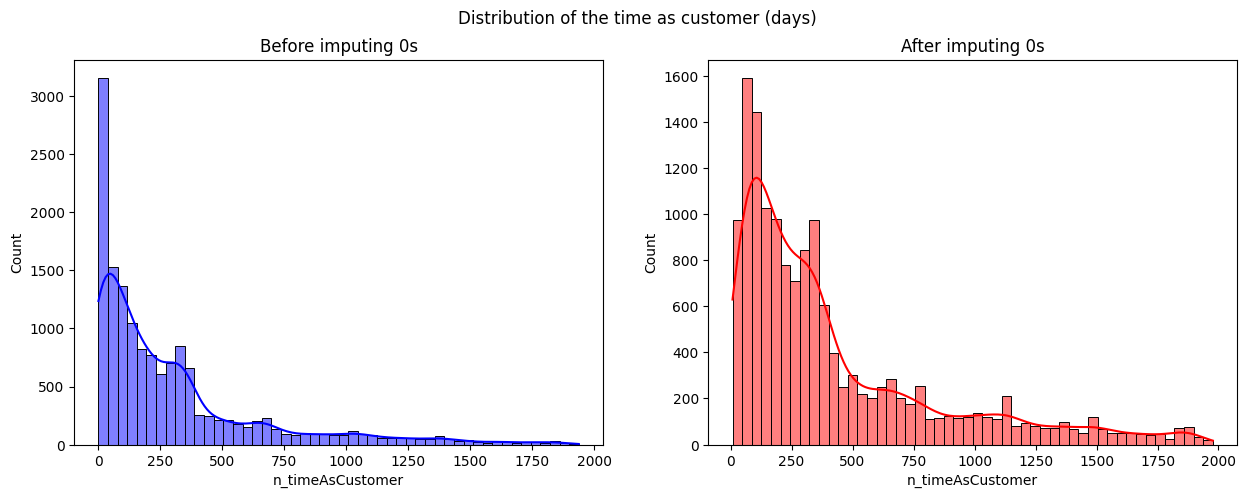

In [67]:
# Plot the distribution of the target variable
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=data_, x='n_timeAsCustomer', ax=axs[0], bins=50, kde=True, color='blue')
sns.histplot(data=data, x='n_timeAsCustomer', ax=axs[1], bins=50, kde=True, color='red')
axs[0].set_title('Before imputing 0s')
axs[1].set_title('After imputing 0s')
fig.suptitle('Distribution of the time as customer (days)')
plt.show()

##### __Last period duration (useless):__
- Periods = Semesters, so to calculate recency we will need another measure
- Therefore, the last period start and finish values are not useful

C:\Users\Mateus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mateus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


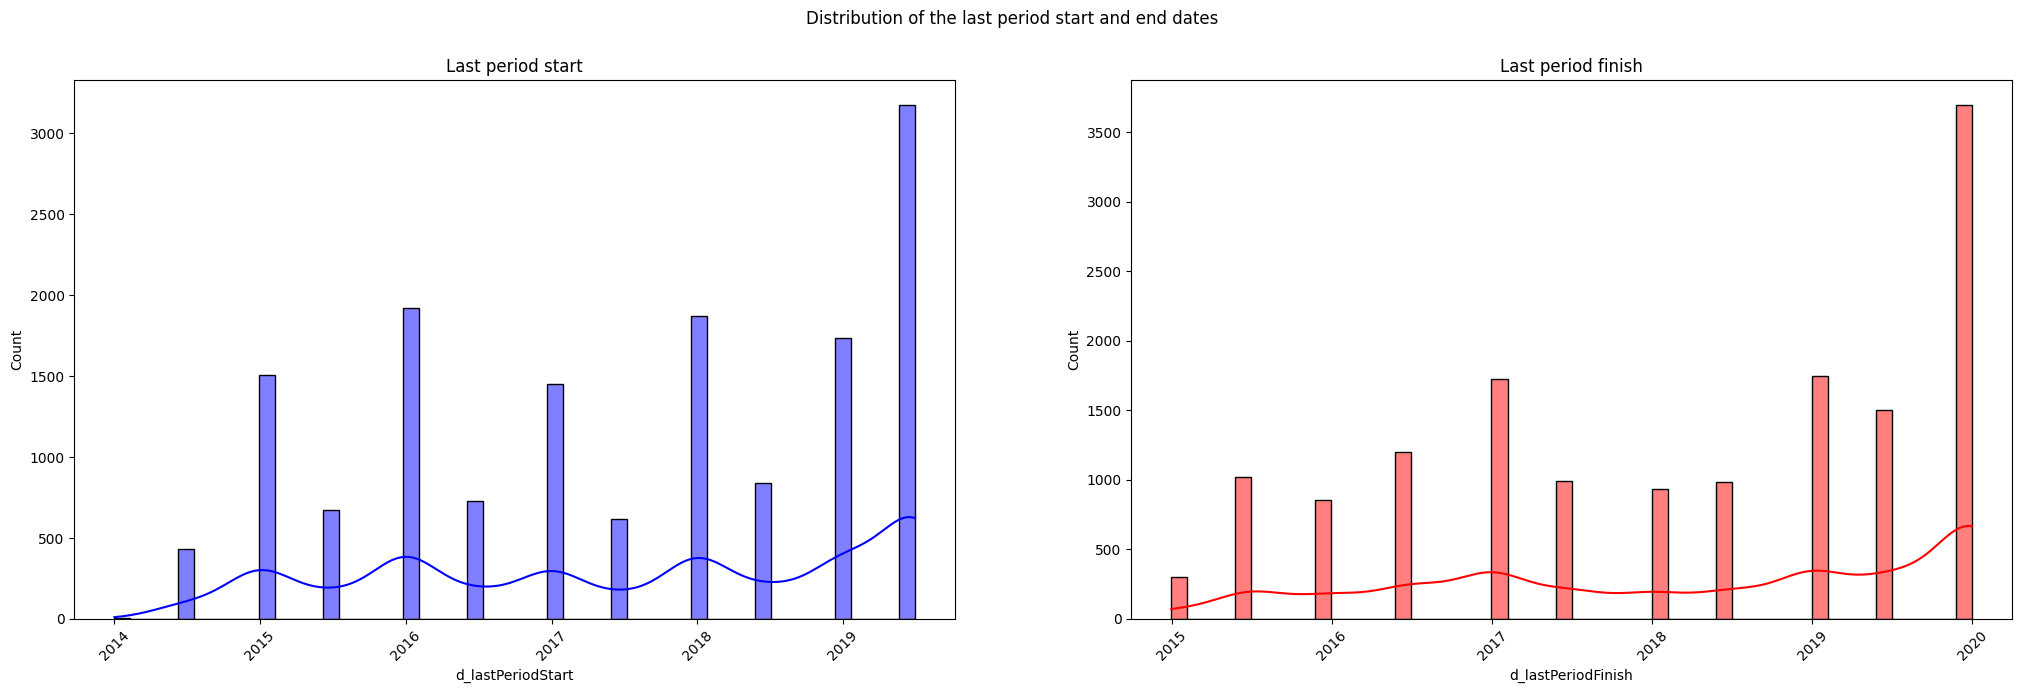

In [68]:
data['d_lastPeriodStart'] = pd.to_datetime(data['d_lastPeriodStart'])
data['d_lastPeriodFinish'] = pd.to_datetime(data['d_lastPeriodFinish'])

# Plot the last period start and end dates
fig, axs = plt.subplots(1, 2, figsize=(25, 7))
sns.histplot(data=data, x='d_lastPeriodStart', ax=axs[0], bins=50, kde=True, color='blue')
sns.histplot(data=data, x='d_lastPeriodFinish', ax=axs[1], bins=50, kde=True, color='red')
axs[0].set_title('Last period start')
axs[1].set_title('Last period finish')

# Rotate xticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)

fig.suptitle('Distribution of the last period start and end dates')
plt.show()

In [69]:
# Remove the date columns
data = data.drop(['d_lastPeriodStart', 'd_lastPeriodFinish'], axis=1)

##### __Days since last visit (recency) + categorical:__

In [70]:
print('Last data available on:', data['d_lastVisit'].value_counts().sort_index(ascending=False).index[0])
data['n_recency'] = (pd.to_datetime(data['d_lastVisit']).max() - pd.to_datetime(data['d_lastVisit'])).dt.days

data['c_recency'] = pd.cut(data['n_recency'], bins=[-1, 7, 14, 30, 60, 90, 365, np.inf], labels=['<1w', '1-2w', '2-4w', '1-2m', '2-3m', '3-12m', '>12m'])
print(data['c_recency'].value_counts(dropna=False))

# Remove the date columns
data = data.drop(['d_lastVisit'], axis=1)

Last data available on: 2019-10-31
c_recency
>12m     9536
3-12m    2557
<1w      1929
1-2w      395
2-4w      262
1-2m      260
2-3m        2
Name: count, dtype: int64


C:\Users\Mateus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mateus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


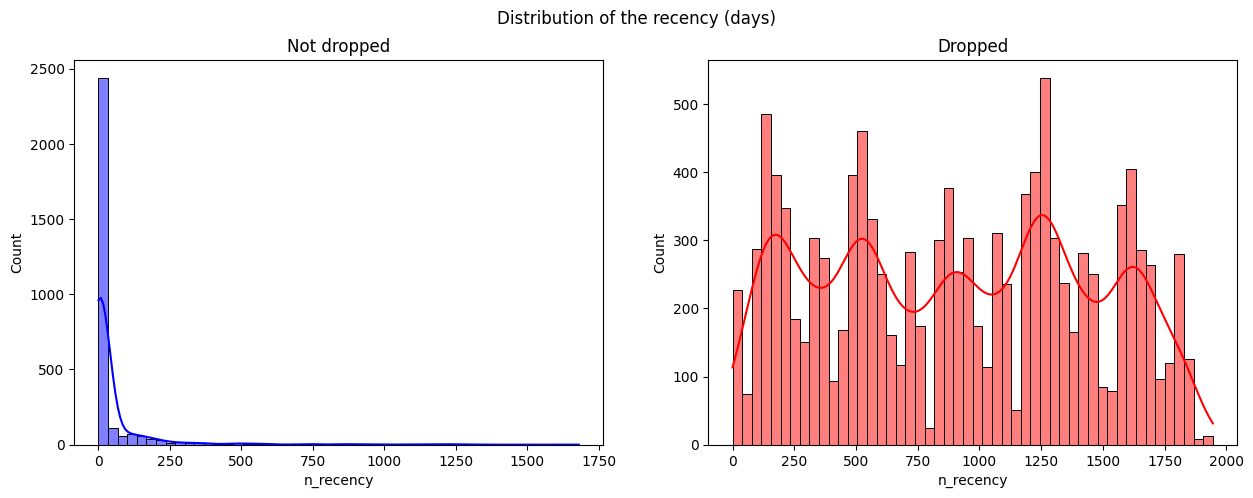

In [71]:
# Plot the n_recency for dropped and not dropped
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=data[data['b_dropout'] == 0], x='n_recency', ax=axs[0], bins=50, kde=True, color='blue')
sns.histplot(data=data[data['b_dropout'] == 1], x='n_recency', ax=axs[1], bins=50, kde=True, color='red')
axs[0].set_title('Not dropped')
axs[1].set_title('Dropped')
fig.suptitle('Distribution of the recency (days)')
plt.show()

### __Relative features__

##### __Number of frequencies per week + categorical:__ 
- The number of frequencies is the number of times a customer went to the facility during its enrollment period.
- We will also delete the number of freqeuncies, as the number of frequencies per week is a better feature.

In [72]:
data['n_frequenciesWeek'] = 7 * data['n_frequencies'] / (data['n_timeAsCustomer'])
# Make a categorical feature
data['c_frequenciesWeek'] = pd.cut(data['n_frequenciesWeek'], bins=[-1, 0.1, 0.2, 0.5, 1, 2, 3, np.inf], labels=['<0.1', '0.1-0.2', '0.2-0.5', '0.5-1', '1-2', '2-3', '>3'])

C:\Users\Mateus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


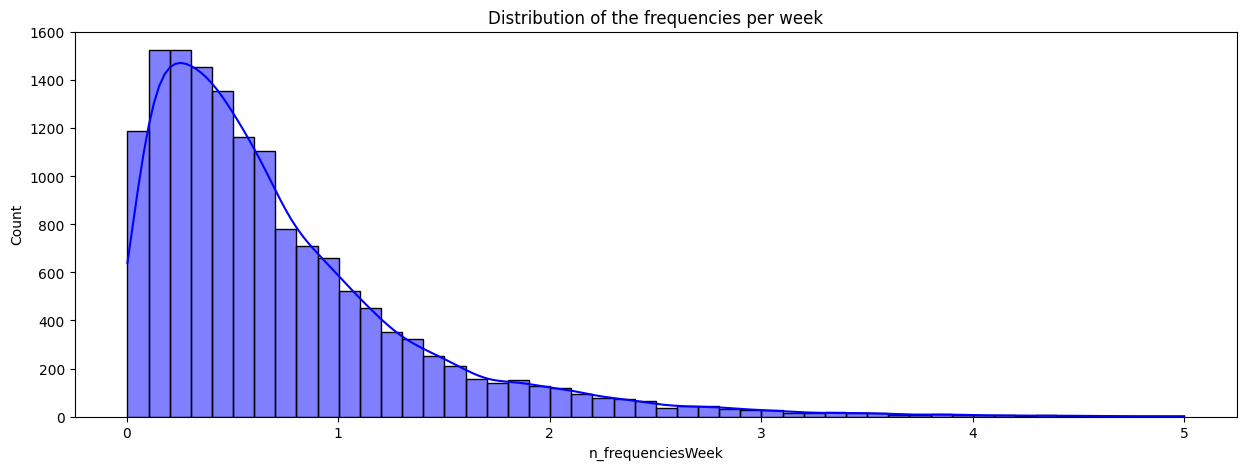

In [73]:
plt.figure(figsize=(15, 5))
sns.histplot(data=data, x='n_frequenciesWeek', bins=50, kde=True, color='blue')
plt.title('Distribution of the frequencies per week')
plt.show()

##### __Attended classes per week & classes per visit + categorical:__
- The number of attended classes per week is the number of times a customer attended a class during its enrollment period.
- We will also delete the number of attended classes, as the number of attended classes per week is a better feature.

In [74]:
data['n_classesWeek'] = 7 * data['n_attendedClasses'] / (data['n_timeAsCustomer'])
data['c_classesWeek'] = pd.cut(data['n_classesWeek'], bins=[-1, 0, 0.1, 0.5, 1, np.inf], labels=['0', '<0.1', '0.1-0.5', '0.5-1', '>1'])
print(data['c_classesWeek'].value_counts())

# Classes per visit
data['n_classesVisit'] = data['n_attendedClasses'] / data['n_frequencies']
data['c_classesVisit'] = pd.cut(data['n_classesVisit'], bins=[-1, 0, 0.5, 1, np.inf], labels=['0', '<0.5', '0.5-1', '>1'])

# Drop the n_attendedClasses
dropped = pd.concat([dropped, data[['n_attendedClasses', 'n_frequencies']]], axis=1)
data = data.drop(['n_attendedClasses', 'n_frequencies'], axis=1)

c_classesWeek
0          10432
0.1-0.5     2239
0.5-1       1150
<0.1         812
>1           308
Name: count, dtype: int64


##### __Service utilization + categorical:__

In [75]:
data['n_ratioUtilization'] = 100 * data['n_realVisits'] / data['n_allowedVisits']
data['n_ratioUtilization'].describe()   

count    14941.000000
mean        15.694226
std         18.079938
min          0.000000
25%          3.224766
50%          9.990010
75%         22.962113
max        254.017626
Name: n_ratioUtilization, dtype: float64

Lets cap it at 100, otherwise it doesnt make sense.

In [76]:
data_ = data.copy()
data.loc[data['n_ratioUtilization'] > 100, 'n_ratioUtilization'] = 100
print(data['n_ratioUtilization'].describe())
data['c_utilization'] = pd.cut(data['n_ratioUtilization'], bins=[-1, 25, 50, 75, np.inf], labels=['<25%', '25-50%', '50-75%', '>75%']) 

count    14941.000000
mean        15.608739
std         17.539408
min          0.000000
25%          3.224766
50%          9.990010
75%         22.962113
max        100.000000
Name: n_ratioUtilization, dtype: float64


C:\Users\Mateus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mateus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


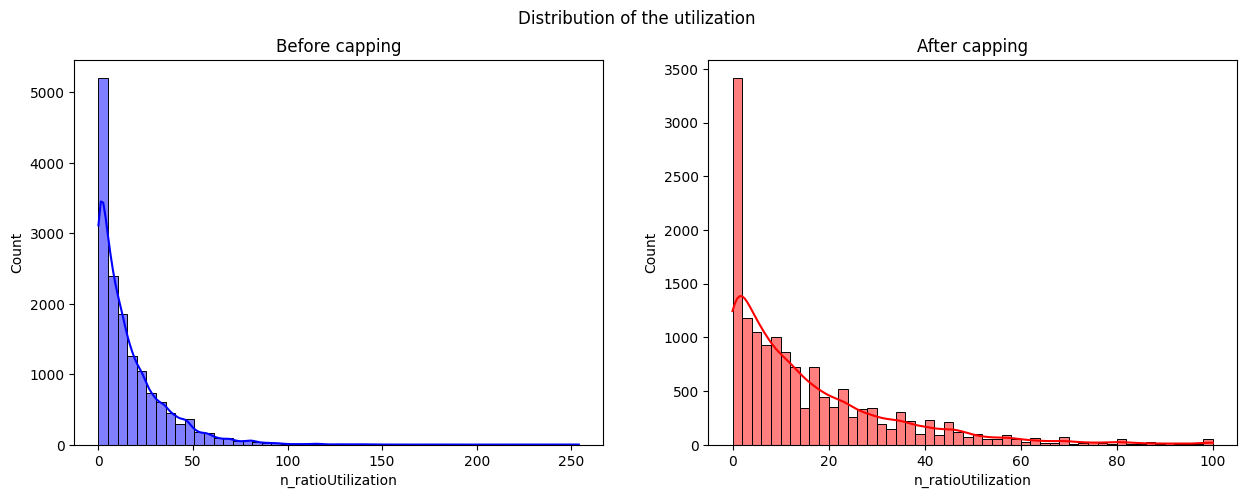

In [77]:
# Plot the distribution of the utilization
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=data_, x='n_ratioUtilization', ax=axs[0], bins=50, kde=True, color='blue')
sns.histplot(data=data, x='n_ratioUtilization', ax=axs[1], bins=50, kde=True, color='red')
axs[0].set_title('Before capping')
axs[1].set_title('After capping')
fig.suptitle('Distribution of the utilization')
plt.show()

### __Monetary features__

__Spent per month:__
- Problem: people pay for their membership in advance, so there wil be noise added for people with a lot of months left in their membership. Moreover, people that have just subscribed will have an even larger value. 
- Solution: we will divide the total spent by the number of months the customer has been a customer. This will give us a better idea of how much a customer spends per month.

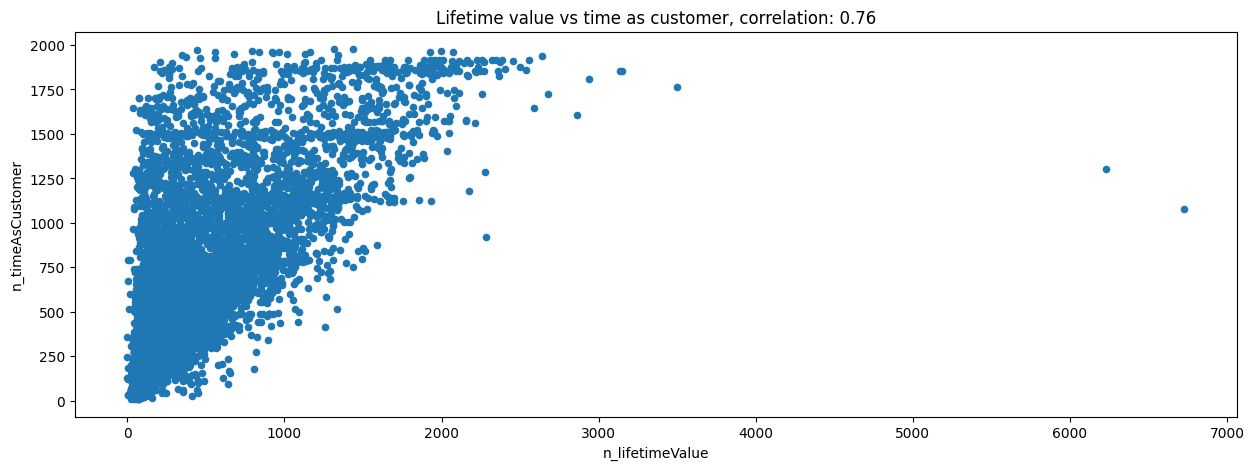

In [78]:
corr_value_timeCustomer = data[['n_timeAsCustomer', 'n_lifetimeValue']].corr().iloc[0, 1]
data.plot.scatter(x='n_lifetimeValue', y='n_timeAsCustomer', figsize=(15, 5), title=f'Lifetime value vs time as customer, correlation: {corr_value_timeCustomer:.2f}')
plt.show()

- There is a very large correlation between the lifetime value and the time as a customer. We can observe that there is a sort of inverse funnel shape, which makes sense. 
- There are definetely some outliers in the data that we will have to deal with.

Number of customers outside the 2 IQR: 273, 1.83%


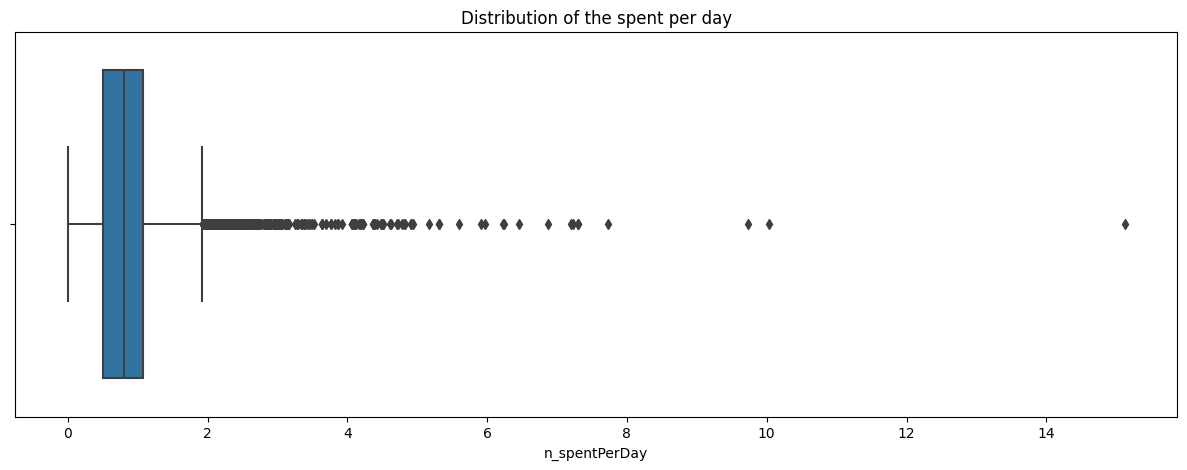

In [79]:
data['n_spentPerDay'] = data['n_lifetimeValue'] / data['n_timeAsCustomer']
spent_per_day = data['n_spentPerDay'].copy()

# Outside the IQR
data['n_spentPerDay'].describe()
IQR = data['n_spentPerDay'].quantile(0.75) - data['n_spentPerDay'].quantile(0.25)
outside = data['n_spentPerDay'].quantile(0.75) + 2 * IQR
counts_outside = data[data['n_spentPerDay'] > outside].shape[0]
print(f'Number of customers outside the 2 IQR: {counts_outside}, {counts_outside/data.shape[0]*100:.2f}%')

# Make a boxplot of the n_spentPerDay
plt.figure(figsize=(15, 5))
sns.boxplot(data=data, x='n_spentPerDay')
plt.title('Distribution of the spent per day')
plt.show()

Okay, but 1.83% of our clients is still a lot to throw away. Lets see if we can do something about it. 

In [80]:
outside_spent = data[data['n_spentPerDay'] > outside]
outside_spent['n_lifetimeValue'].describe()

count     273.000000
mean      211.462930
std       588.785991
min        20.900000
25%        67.200000
50%        83.100000
75%       141.350000
max      6727.800000
Name: n_lifetimeValue, dtype: float64

This is odd, as the people that have a very high n_spentPerDay dont have such high lifetimevalues. Lets see if we can find something else.

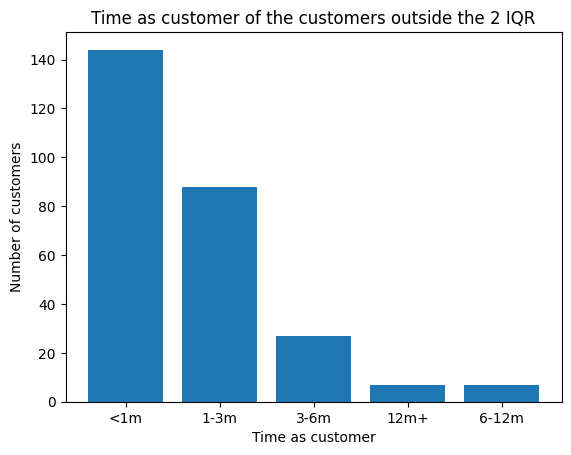

In [81]:
plt.bar(x=outside_spent['c_timeAsCustomer'].unique(), height=outside_spent['c_timeAsCustomer'].value_counts())
plt.title('Time as customer of the customers outside the 2 IQR')
plt.xlabel('Time as customer')
plt.ylabel('Number of customers')
plt.show()

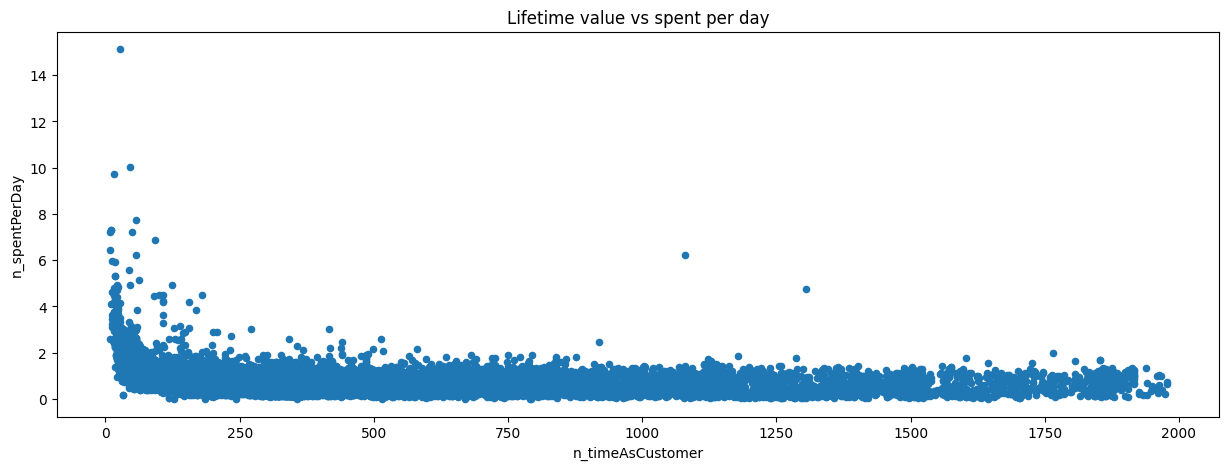

In [82]:
data.plot.scatter(x='n_timeAsCustomer', y='n_spentPerDay', figsize=(15, 5), title=f'Lifetime value vs spent per day')
plt.show()

Now it makes sense! When a customer signs up, we might have to pay a fee for the subscription. This is why the n_spentPerDay is so high. Lets see if we can find a way to deal with this later on.

In [83]:
data['n_spentPerMonth'] = data['n_spentPerDay'] * 30
data.drop(['n_spentPerDay'], axis=1, inplace=True)

### __Other__

#### __Different activities:__
- Lets create a feature that is the maximum of the low count activities. This will give us a better idea of the activities that a customer does.

In [84]:
data['b_rareActivities'] = dropped[['b_specialActivities', 'b_racketActivities', 'OtherActivities']].fillna(0).max(axis=1)

## __5. Variable correlations__
- Correlation between numerical variables

__Correlations for the numerical variables__

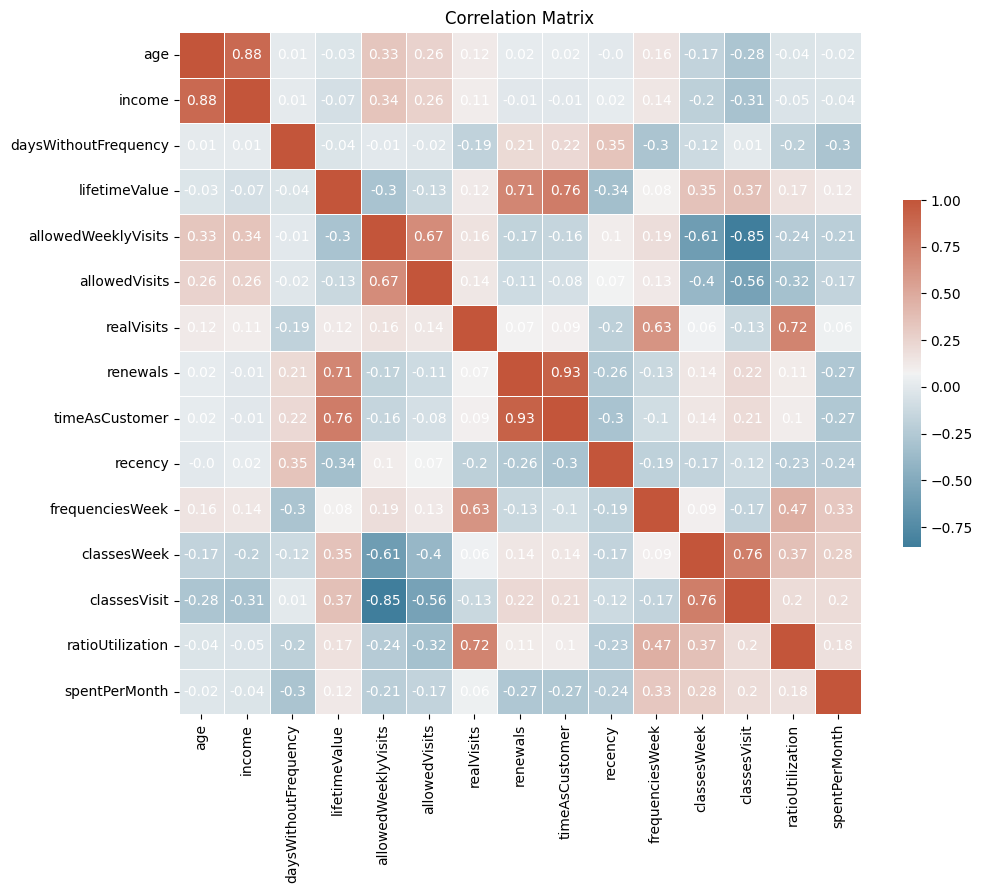

In [38]:
numerical_features = [col for col in data.columns if col.startswith('n_')]

# Correlation between numerical features sns
corr = data[numerical_features].corr()
# mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Remove the n_ prefix
corr.columns = corr.columns.str.replace('n_', '')
corr.index = corr.index.str.replace('n_', '')
sns.heatmap(corr, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
# Add annotation
for i in range(len(corr)):
    for j in range(len(corr)):
        if i != j:
            ax.text(i+0.5, j+0.5, round(corr.iloc[i,j],2), ha="center", va="center", color="w")
ax.set_title('Correlation Matrix')
plt.show()

1. High correlations -> between age and income and renewals and enrollmentDuration, we can drop the age (which will be used after the clustering algorithm is done for visualization) and the renewals, because the renewals are less correlated with the other variables than the enrollment duration -> $[age, renewals]$

2. Allowed weekly visits is highly correlated with the total number of allowed visits, so we will drop the total allowed visits because it is less correlated with the other variables and because we already used it to create the ratioUtilization variable -> $[allowedVisits]$

3. We will also drop the daysWithoutFrequency variable, which means the number of days that a customer needed to not visit the facility to be considered a dropout, because of relevancy and low correlation to other features -> $[daysWithoutFrequency]$

4. Delete lifetime value, because it has outliers and those were already handled in the spentPerMonth feature. Moreover, it is highly correlated with the time as a customer, which is a better feature -> $[lifetimeValue]$

5. Drop the number of real visits as it was already used in feature engineering for the ratio utilization, and we already have the visits per week  -> $[realVisits]$

6. Drop the classes per week, as it is highly correlated with the classes per visit, and is much more skewed -> $[classesPerWeek]$

In [39]:
dropped = pd.concat([data[['n_renewals', 'n_allowedVisits', 'n_daysWithoutFrequency', 'n_lifetimeValue', 'n_realVisits', 'n_classesWeek']], dropped], axis=1)
data = data.drop(['n_renewals', 'n_allowedVisits', 'n_daysWithoutFrequency', 'n_lifetimeValue', 'n_realVisits', 'n_classesWeek'], axis=1)

Before dropping age, lets see how it is distributed

C:\Users\Mateus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


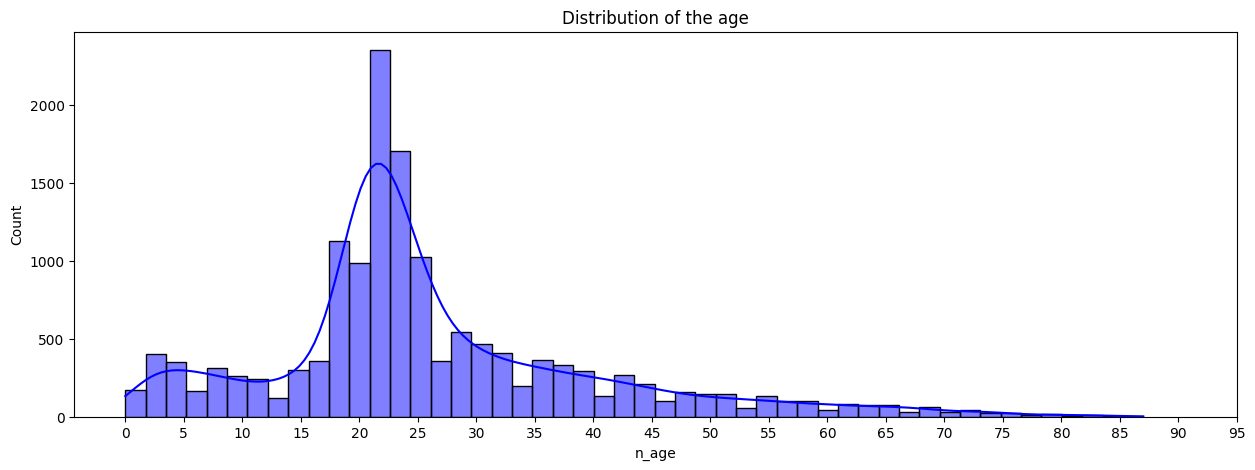

In [40]:
# Plot a histogram of age 
plt.figure(figsize=(15, 5))
sns.histplot(data=data, x='n_age', bins=50, kde=True, color='blue')
plt.title('Distribution of the age')
plt.xticks([i for i in range(0, 100, 5)])
plt.show()

People aged 80+ and that are dropouts are to be dropped from the dataset, as they have probably passed away.

In [45]:
data = data[~((data['n_age'] >= 80) & (data['b_dropout'] == 1))]
data.drop(['n_age'], axis=1, inplace=True)

__Data exploration:__

C:\Users\Mateus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mateus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Mateus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf value

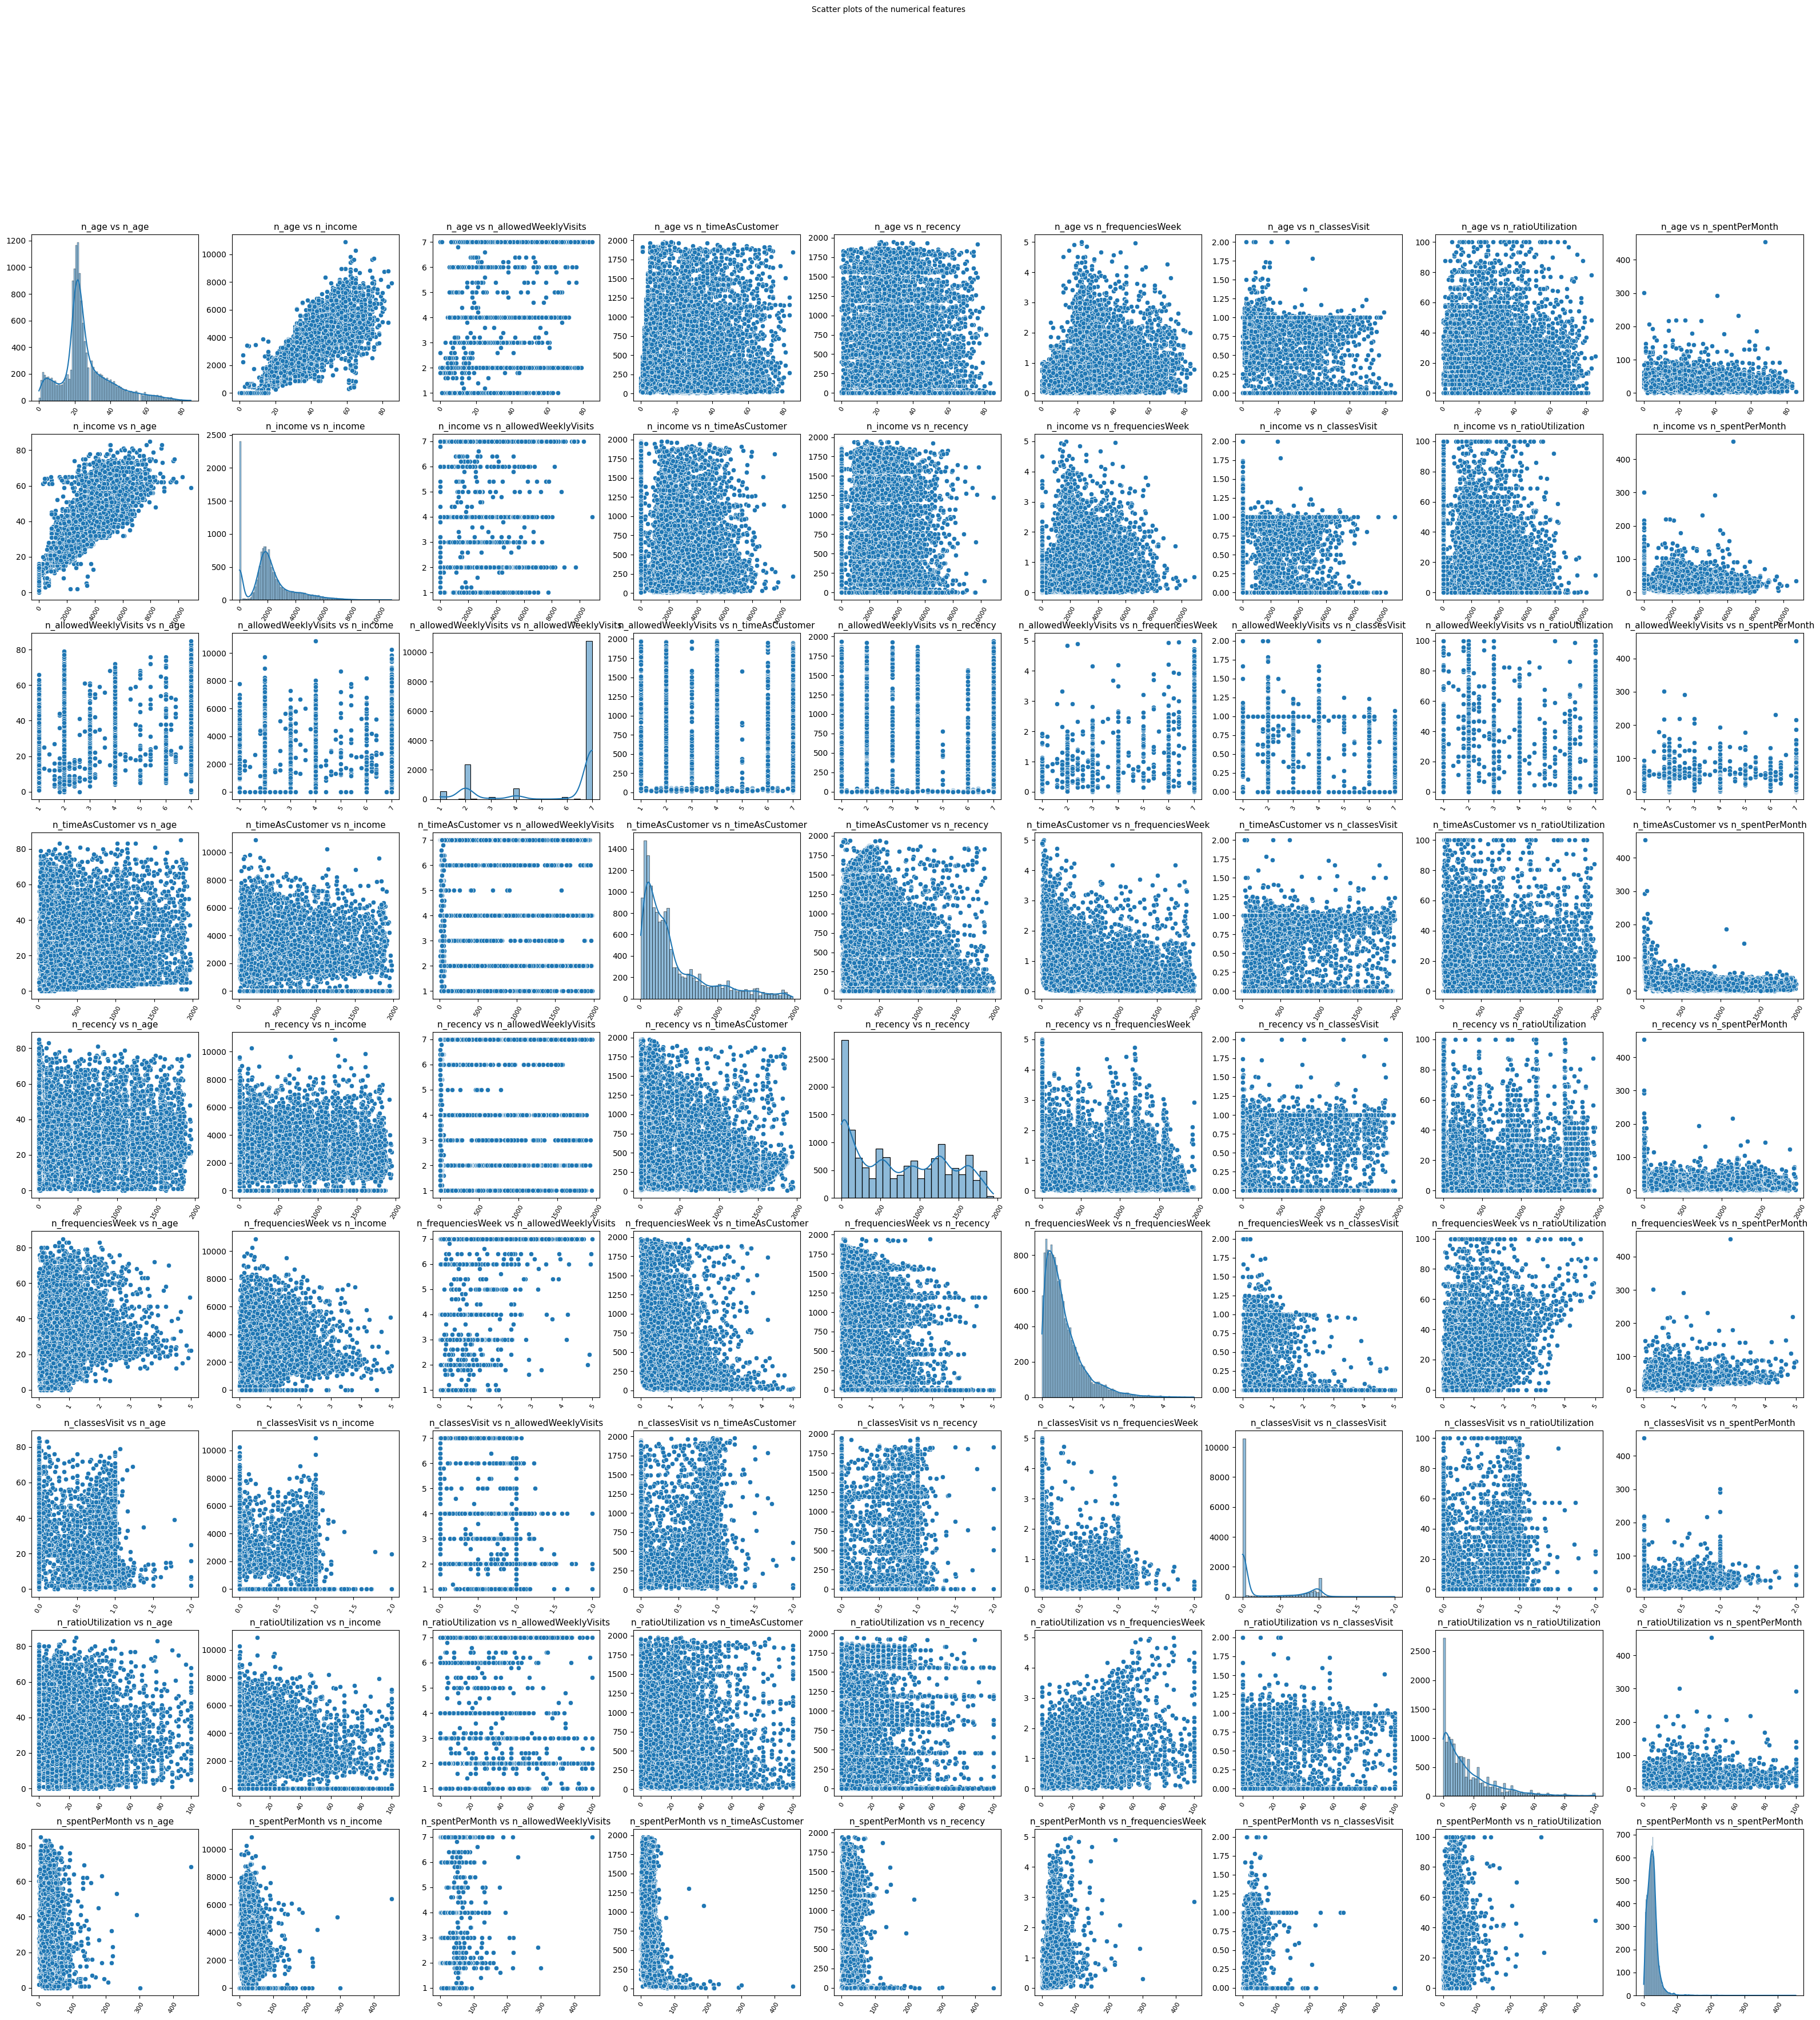

In [42]:
# Make scater plots of the numerical features
numerical_features = [col for col in data.columns if col.startswith('n_')]
fig, axs = plt.subplots(nrows = len(numerical_features), ncols = len(numerical_features), figsize=(40, 40))

for i in range(len(numerical_features)):
    for j in range(len(numerical_features)):
        if i != j:
            sns.scatterplot(data=data, x=numerical_features[i], y=numerical_features[j], ax=axs[i, j])
        else:
            sns.histplot(data=data, x=numerical_features[i], ax=axs[i, j], kde=True)
        axs[i, j].set_xlabel('')
        axs[i, j].set_ylabel('')
        axs[i, j].set_title(f'{numerical_features[i]} vs {numerical_features[j]}', fontsize=11)
fig.suptitle('Scatter plots of the numerical features', fontsize=10)

# Rotate xticks
for ax in axs.flat:
    plt.sca(ax)
    plt.xticks(rotation=60, fontsize=8)
plt.show()

## __6. Outlier detection - Numerical__

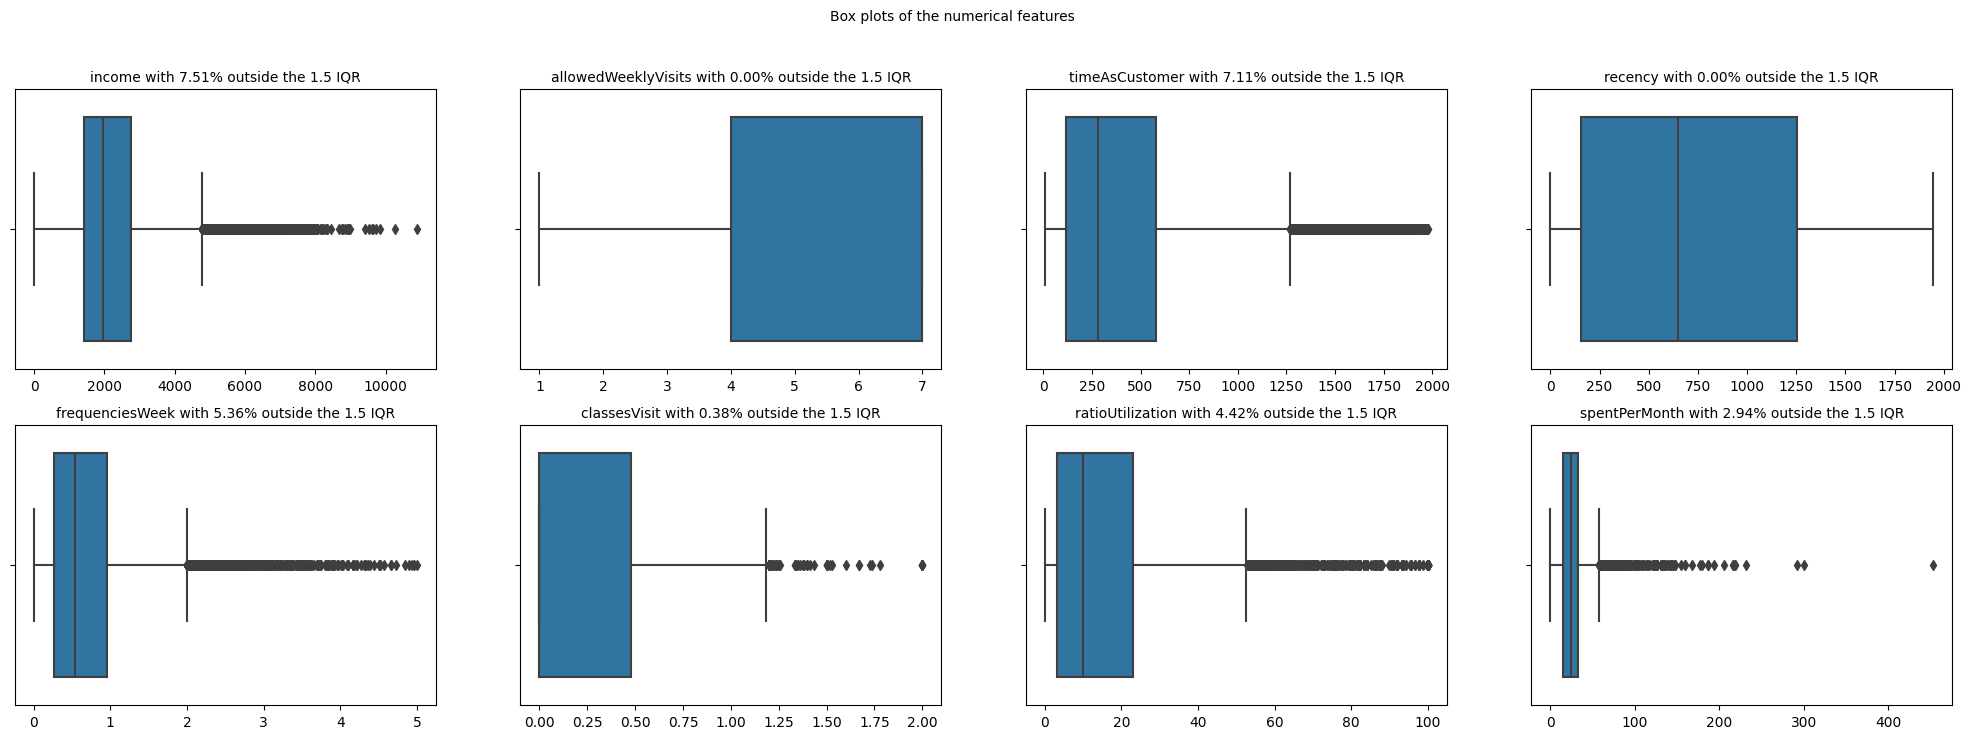

In [47]:
# Plot all the numerical variables box plots
numerical_features = [col for col in data.columns if col.startswith('n_')]
fig, axs = plt.subplots(nrows = int(len(numerical_features)/4), ncols=4 , figsize=(25, 8))

for i in range(len(numerical_features)):
    # Calculate the IQR
    IQR = data[numerical_features[i]].quantile(0.75) - data[numerical_features[i]].quantile(0.25)
    # Calculate the upper and lower bound
    lower = data[numerical_features[i]].quantile(0.25) - 1.5 * IQR
    upper = data[numerical_features[i]].quantile(0.75) + 1.5 * IQR
    # Get the number of features outise the iqr
    outside = data[data[numerical_features[i]] > upper].shape[0]
    pct = outside / data.shape[0] * 100

    sns.boxplot(data=data, x=numerical_features[i], ax=axs[int(i/4), i%4])
    axs[int(i/4), i%4].set_xlabel('')
    axs[int(i/4), i%4].set_ylabel('')
    axs[int(i/4), i%4].set_title(f'{numerical_features[i].split("_")[1]} with {pct:.2f}% outside the 1.5 IQR', fontsize=10)
fig.suptitle('Box plots of the numerical features', fontsize=10)
plt.show()

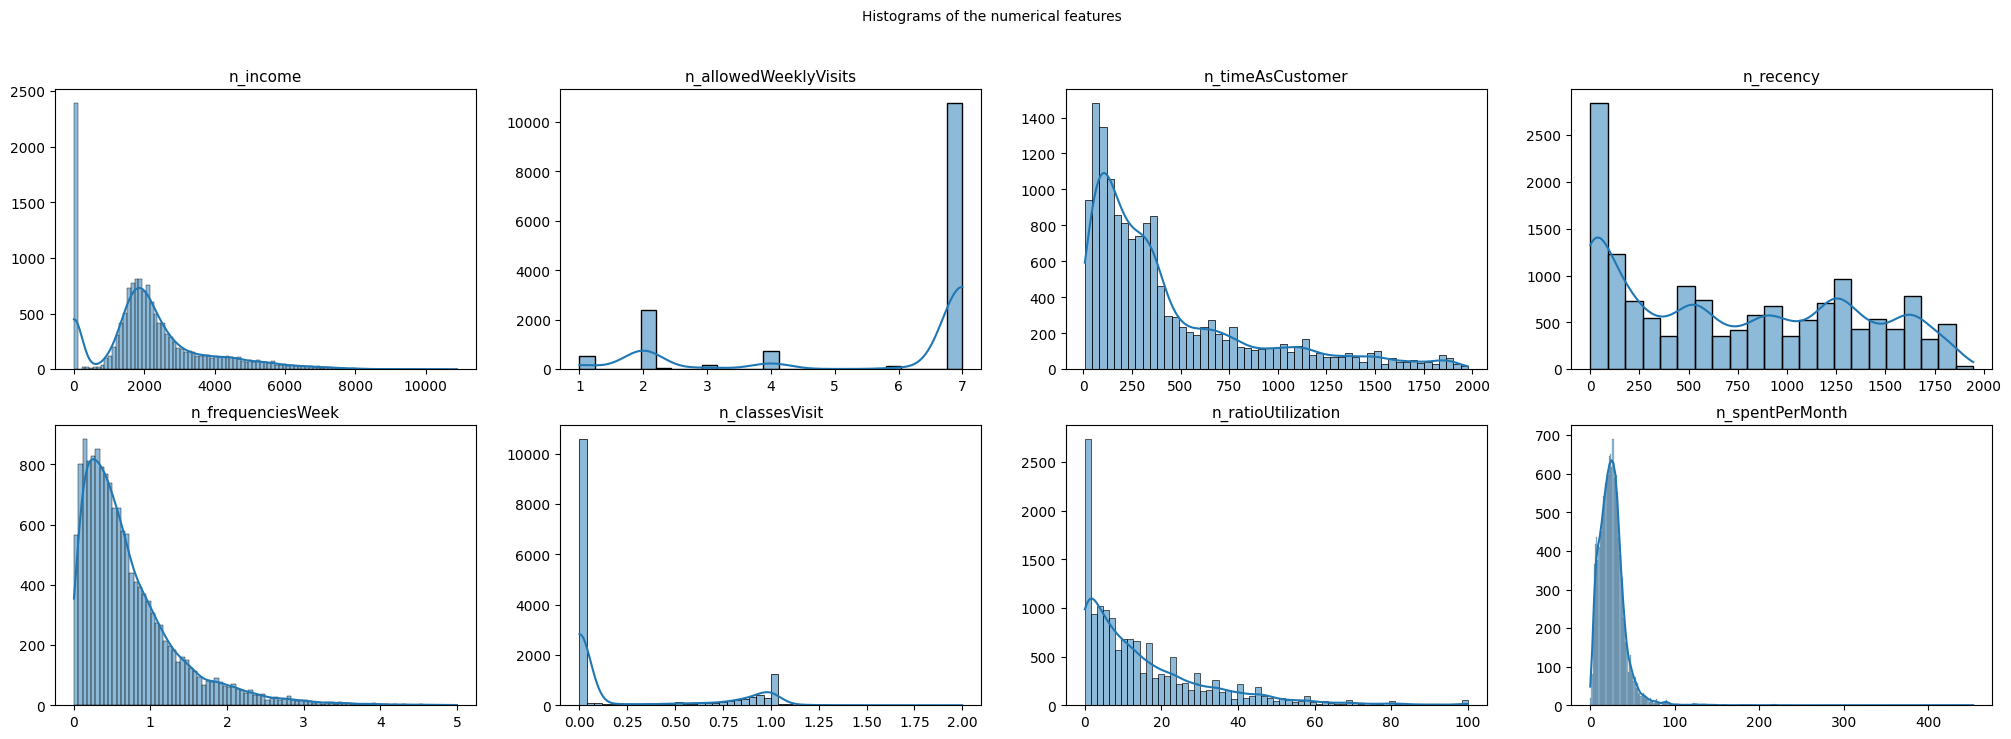

In [ ]:
# Plot the histograms of the numerical features
fig, axs = plt.subplots(nrows = int(len(numerical_features)/4), ncols=4 , figsize=(25, 8))

for i in range(len(numerical_features)):
    sns.histplot(data=data, x=numerical_features[i], ax=axs[int(i/4), i%4], kde=True)
    axs[int(i/4), i%4].set_xlabel('')
    axs[int(i/4), i%4].set_ylabel('')
    axs[int(i/4), i%4].set_title(f'{numerical_features[i]}', fontsize=11)
fig.suptitle('Histograms of the numerical features', fontsize=10)
plt.show()

#### __What we get from looking at this:__


##### **Income:** 
1. Many people have income = 0 (2123), which means that they are not working. These are people under 18. This could be a problem for the models, and we have to think about how to deal with this.

In [ ]:
data_original[data_original['Income'] == 0]['Age'].describe()

count    2123.000000
mean        8.040980
std         4.764651
min         0.000000
25%         4.000000
50%         8.000000
75%        12.000000
max        16.000000
Name: Age, dtype: float64

2. We have some outliers in the income, but its not a problem at all. We know that income doesn't follow a normal distribution, as the world is unequal. Lets try the log transformation and see if it helps.

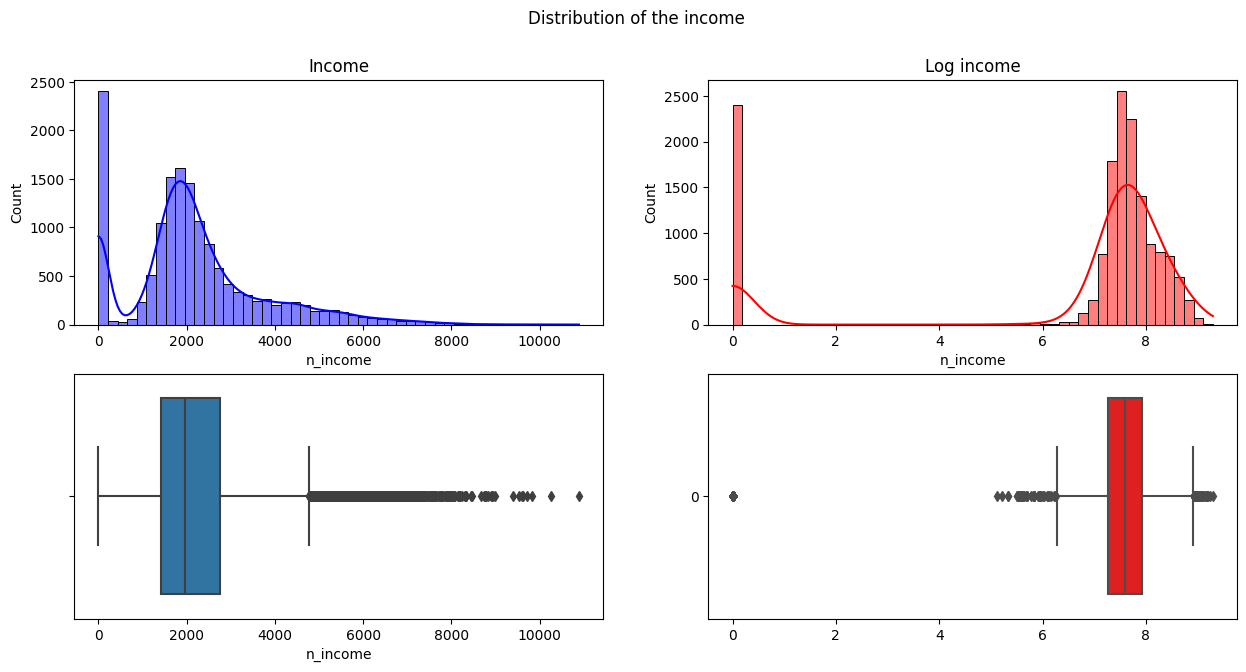

In [ ]:
# Lets clip income to 4500
log_income = np.log(data['n_income']+1)

# Plot the distribution of the income
fig, axs = plt.subplots(2, 2, figsize=(15, 7))
sns.histplot(data=data, x='n_income', ax=axs[0, 0], bins=50, kde=True, color='blue')
sns.histplot(data=log_income, ax=axs[0, 1], bins=50, kde=True, color='red')
sns.boxplot(data=data, x='n_income', ax=axs[1, 0])
sns.boxplot(data=log_income, ax=axs[1, 1], color='red', orient='h')
axs[0, 0].set_title('Income')
axs[0, 1].set_title('Log income')
fig.suptitle('Distribution of the income')
plt.show()

There would be a clear sepparation in the data, but we dont't know if we want to cluster the data in such a way. We will have to think about this.

3. What about clipping ? 

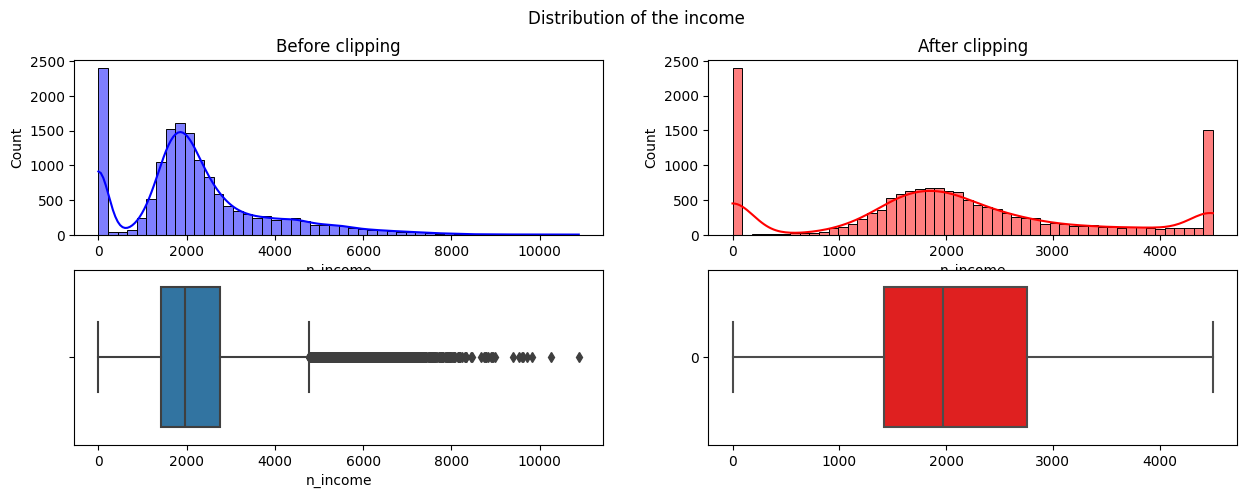

In [ ]:
clipped = data['n_income'].clip(upper=4500)

# Plot the distribution of the income
fig, axs = plt.subplots(2, 2, figsize=(15, 5))
sns.histplot(data=data, x='n_income', ax=axs[0, 0], bins=50, kde=True, color='blue')
sns.histplot(data=clipped, ax=axs[0, 1], bins=50, kde=True, color='red')
sns.boxplot(data=data, x='n_income', ax=axs[1, 0])
sns.boxplot(data=clipped, ax=axs[1, 1], color='red', orient='h')
axs[0, 0].set_title('Before clipping')
axs[0, 1].set_title('After clipping')
fig.suptitle('Distribution of the income')
plt.show()


4. Log transforming and then clipping ?

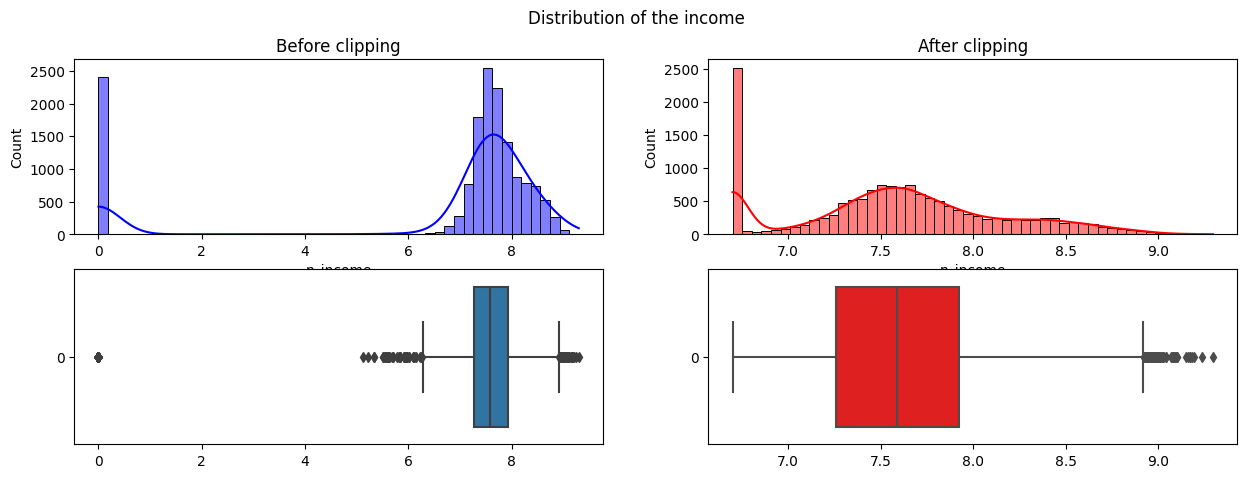

In [ ]:
log_clipped = log_income.clip(lower=6.7)

# Plot the distribution of the income
fig, axs = plt.subplots(2, 2, figsize=(15, 5))
sns.histplot(data=log_income, ax=axs[0, 0], bins=50, kde=True, color='blue')
sns.histplot(data=log_clipped, ax=axs[0, 1], bins=50, kde=True, color='red')
sns.boxplot(data=log_income, ax=axs[1, 0] , orient='h')
sns.boxplot(data=log_clipped, ax=axs[1, 1], color='red', orient='h')
axs[0, 0].set_title('Before clipping')
axs[0, 1].set_title('After clipping')
fig.suptitle('Distribution of the income')
plt.show()

__Conclusion:__ Clipping is the best alternative, as it will not skew the data too much and it will smooth the outliers.

In [ ]:
data['n_income'] = clipped

##### **Allowed weekly visits:**
- It doesn't seem to be all that relevant, but we will still include it as it is quite regular and well behaved.

##### **Number of time as a customer:**
- It has quite a few outliers, which is normal, as some people have been customers for a very long time. We can either clip the outliers or use a log transformation. Lets see what happens.


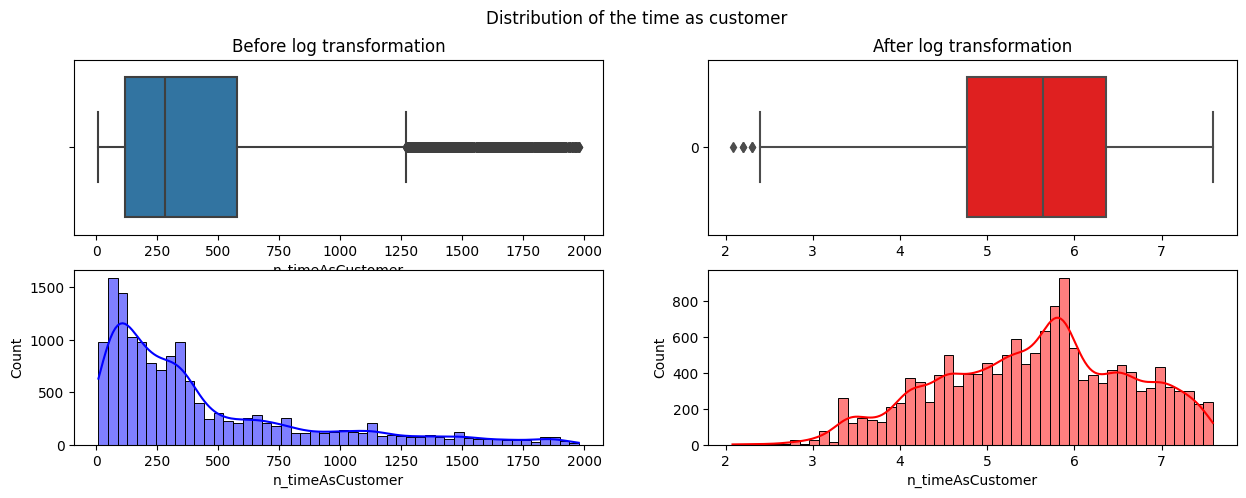

In [ ]:
# Log transform the n_timeAsCustomer
time_as_customer = np.log(data['n_timeAsCustomer'])

# Plot the box plot of the log transformed n_timeAsCustomer
fig, axs = plt.subplots(2,2, figsize=(15, 5))
sns.boxplot(data=data, x='n_timeAsCustomer', ax=axs[0, 0])
sns.boxplot(data=time_as_customer, ax=axs[0, 1], color='red', orient='h')
sns.histplot(data=data, x='n_timeAsCustomer', ax=axs[1, 0], bins=50, kde=True, color='blue')
sns.histplot(data=time_as_customer, ax=axs[1, 1], bins=50, kde=True, color='red')
axs[0, 0].set_title('Before log transformation')
axs[0, 1].set_title('After log transformation')
fig.suptitle('Distribution of the time as customer')
plt.show()

Looks good, lets keep it 

In [ ]:
data['n_timeAsCustomer'] = time_as_customer

##### **Recency:**
- Looks good as it is, nothing to do here.

##### **Frequencies per week:**
- This is a crucial feature, and we wont want to skew it too much. Lets try clipping it to 4 and the log transformation.

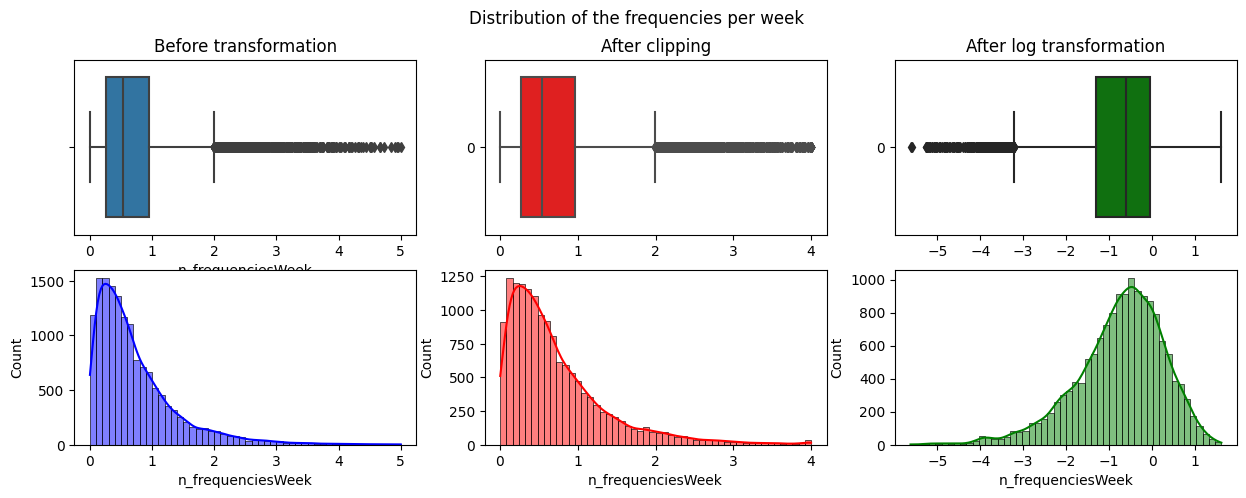

In [ ]:
# Lets try clipping to 4 and log transform
clipped = data['n_frequenciesWeek'].clip(upper=4)
log_freq = np.log(data['n_frequenciesWeek'])

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))
sns.boxplot(data=data, x='n_frequenciesWeek', ax=axs[0, 0])
sns.boxplot(data=clipped, ax=axs[0, 1], color='red', orient='h')
sns.boxplot(data=log_freq, ax=axs[0, 2], color='green', orient='h')
sns.histplot(data=data, x='n_frequenciesWeek', ax=axs[1, 0], bins=50, kde=True, color='blue')
sns.histplot(data=clipped, ax=axs[1, 1], bins=50, kde=True, color='red')
sns.histplot(data=log_freq, ax=axs[1, 2], bins=50, kde=True, color='green')
axs[0, 0].set_title('Before transformation')
axs[0, 1].set_title('After clipping')
axs[0, 2].set_title('After log transformation')
fig.suptitle('Distribution of the frequencies per week')
plt.show()

- Since we care about high frequencies, and there is a huge difference between a customer that visits the gym 2 times a week and one that visits 3,4, we cannot clip to 2, which would reduce totally the outliers. 
- We opted for clipping the log transformation to -3, as e^-3 = 0.05, which is basically the same as 0.03, and it will not skew the data too much.

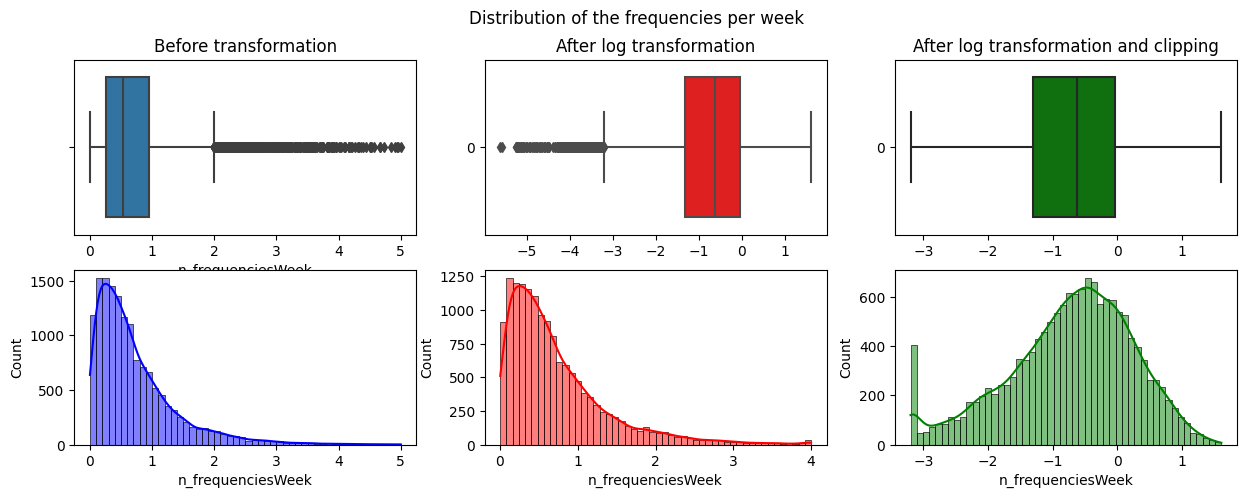

In [ ]:
log_clipped = log_freq.clip(lower=-3.2)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))
sns.boxplot(data=data, x='n_frequenciesWeek', ax=axs[0, 0])
sns.boxplot(data=log_freq, ax=axs[0, 1], color='red', orient='h')
sns.boxplot(data=log_clipped, ax=axs[0, 2], color='green', orient='h')
sns.histplot(data=data, x='n_frequenciesWeek', ax=axs[1, 0], bins=50, kde=True, color='blue')
sns.histplot(data=clipped, ax=axs[1, 1], bins=50, kde=True, color='red')
sns.histplot(data=log_clipped, ax=axs[1, 2], bins=50, kde=True, color='green')
axs[0, 0].set_title('Before transformation')
axs[0, 1].set_title('After log transformation')
axs[0, 2].set_title('After log transformation and clipping')
fig.suptitle('Distribution of the frequencies per week')
plt.show()

In [ ]:
# Lets keep the log_clipped, but lets add 3.2 so that the minimum is 0
data['n_frequenciesWeek'] = log_clipped + 3.2

NameError: name 'log_clipped' is not defined

##### **Classes per visit:**
- The main probelm here is that we have 70% of people that don't go to classes. Although we don't have outliers. We need to be careful with this feature !

##### **Ratio utilization:**
- Ratio utilization is important and has some outliers. Lets try to apply the log transformation and see what happens.

In [ ]:
log_ratio = np.log(data['n_ratioUtilization'] + 1)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))
sns.boxplot(data=data, x='n_ratioUtilization', ax=axs[0, 0])
sns.boxplot(data=log_ratio, ax=axs[0, 1], color='red', orient='h')
sns.histplot(data=data, x='n_ratioUtilization', ax=axs[1, 0], bins=50, kde=True, color='blue')
sns.histplot(data=log_ratio, ax=axs[1, 1], bins=50, kde=True, color='red')
axs[0, 0].set_title('Before transformation')
axs[0, 1].set_title('After log transformation')
fig.suptitle('Distribution of the ratio utilization')
plt.show()

NameError: name 'np' is not defined

Looks good after the log transformation, lets keep it.

In [ ]:
data['n_ratioUtilization'] = log_ratio

NameError: name 'log_ratio' is not defined

##### **Spent per month:**
- We have some outliers. Its a gym, people aren't going to spend more than 60 euros per month in it. Lets cap to 60 and see what happens.

In [ ]:
spent_per_day

0        1.540517
1        1.204020
2        1.253333
3        0.971250
4        0.479692
           ...   
14937    1.272169
14938    1.317433
14939    1.453333
14940    1.294910
14941    0.788679
Name: n_spentPerDay, Length: 14941, dtype: float64

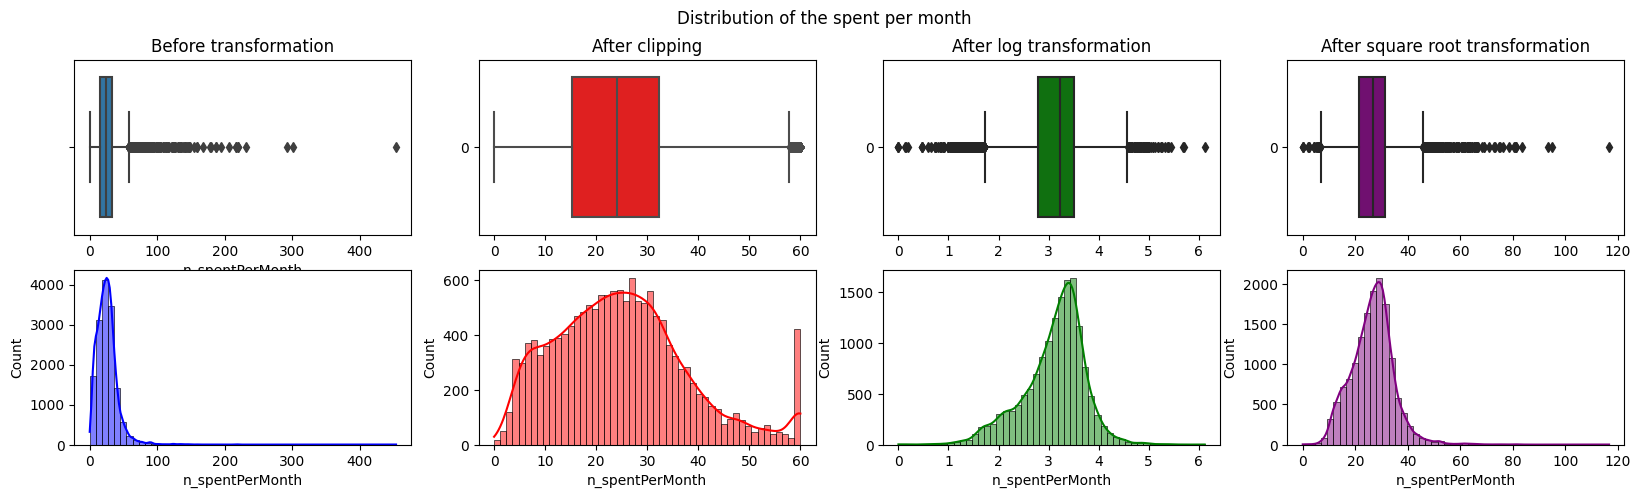

In [ ]:
spent_per_month = data['n_spentPerMonth'].copy()
clipped = data['n_spentPerMonth'].clip(upper=60)
log_spent = np.log(spent_per_month + 1)
sq_spent = np.sqrt(spent_per_month*30)

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 5))
sns.boxplot(data=data, x='n_spentPerMonth', ax=axs[0, 0])
sns.boxplot(data=clipped, ax=axs[0, 1], color='red', orient='h')
sns.boxplot(data=log_spent, ax=axs[0, 2], color='green', orient='h')
sns.boxplot(data=sq_spent, ax=axs[0, 3], color='purple', orient='h')
sns.histplot(data=data, x='n_spentPerMonth', ax=axs[1, 0], bins=50, kde=True, color='blue')
sns.histplot(data=clipped, ax=axs[1, 1], bins=50, kde=True, color='red')
sns.histplot(data=log_spent, ax=axs[1, 2], bins=50, kde=True, color='green')
sns.histplot(data=sq_spent, ax=axs[1, 3], bins=50, kde=True, color='purple')
axs[0, 0].set_title('Before transformation')
axs[0, 1].set_title('After clipping')
axs[0, 2].set_title('After log transformation')
axs[0, 3].set_title('After square root transformation')
fig.suptitle('Distribution of the spent per month')
plt.show()

Clipping to 60 seems like a reasonable choice.

In [ ]:
data['n_spentPerMonth'] = clipped

## __7. Other features visualization__
- We don't have native categorical features in our dataset. The ones we do were engineered to be used latter on after the clustering algorithm is done.

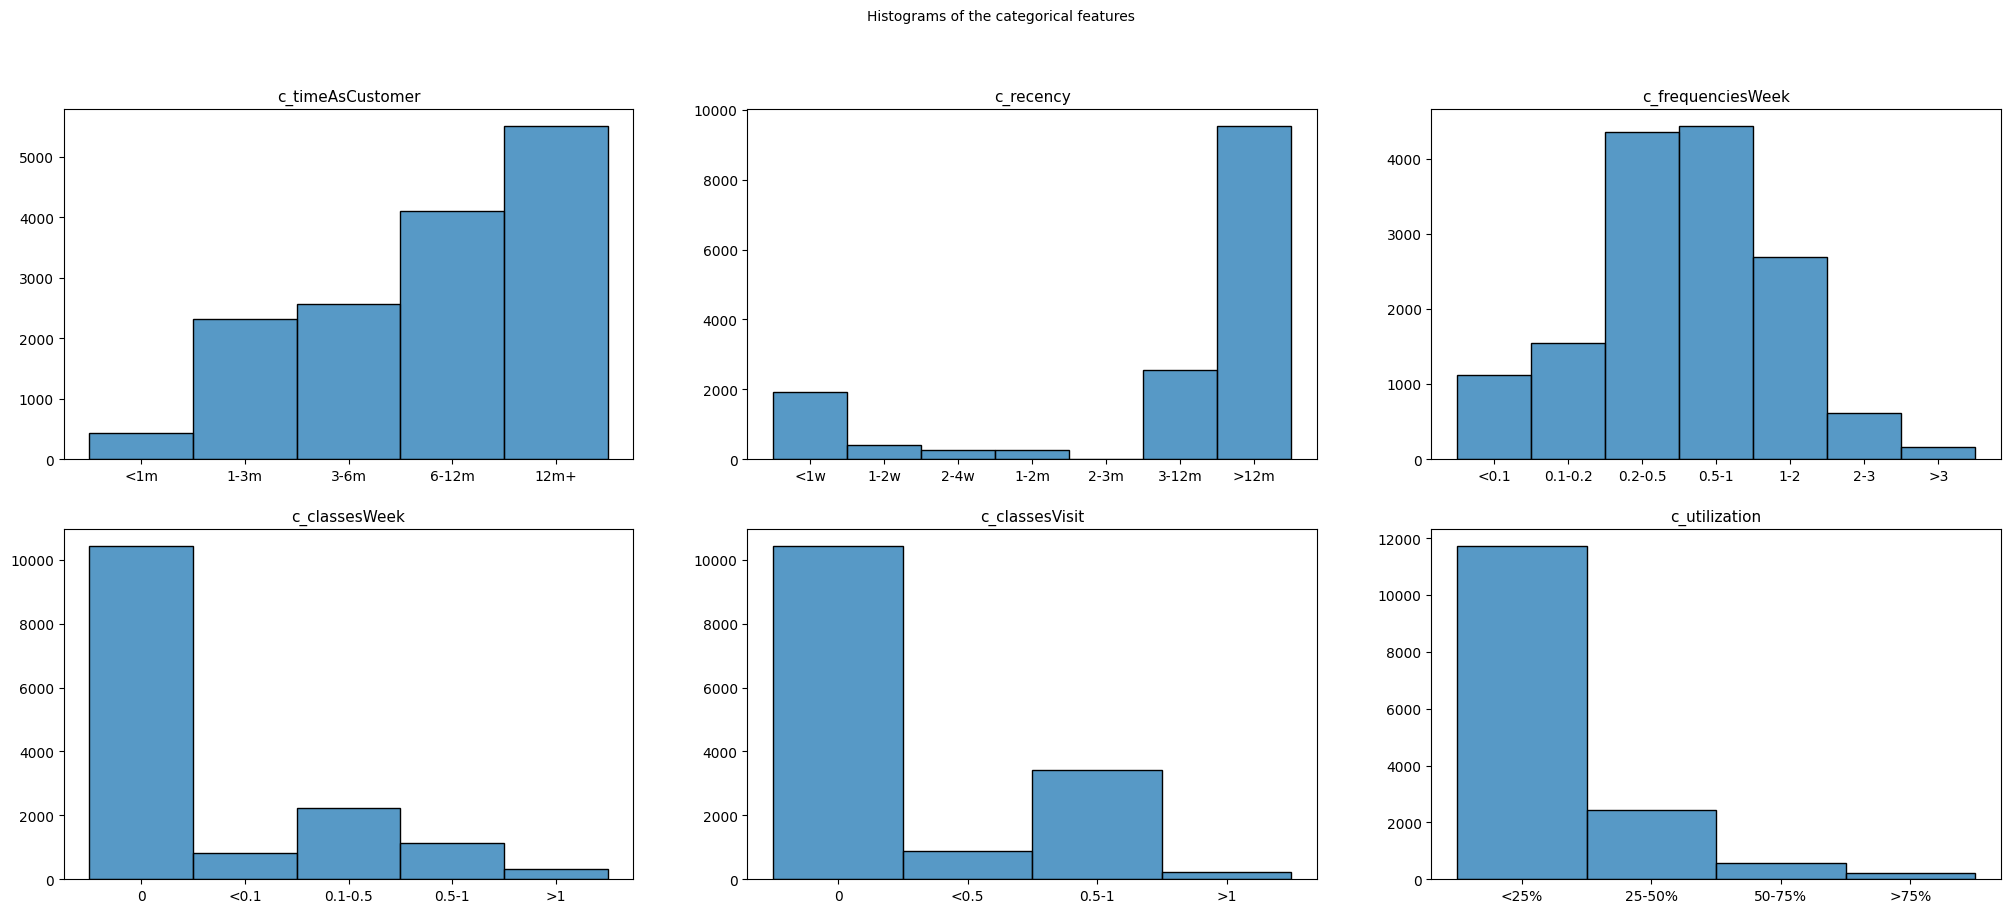

In [ ]:
# Make a histogram for every categorical feature
categorical_features = [col for col in data.columns if col.startswith('c_')]
fig, axs = plt.subplots(nrows = 2, ncols=3 , figsize=(25, 10))

for i in range(len(categorical_features)):
    sns.histplot(data=data, x=categorical_features[i], ax=axs[int(i/3), i%3])
    axs[int(i/3), i%3].set_xlabel('')
    axs[int(i/3), i%3].set_ylabel('')
    axs[int(i/3), i%3].set_title(f'{categorical_features[i]}', fontsize=11)
fig.suptitle('Histograms of the categorical features', fontsize=10)
plt.show()


#### __Binary__

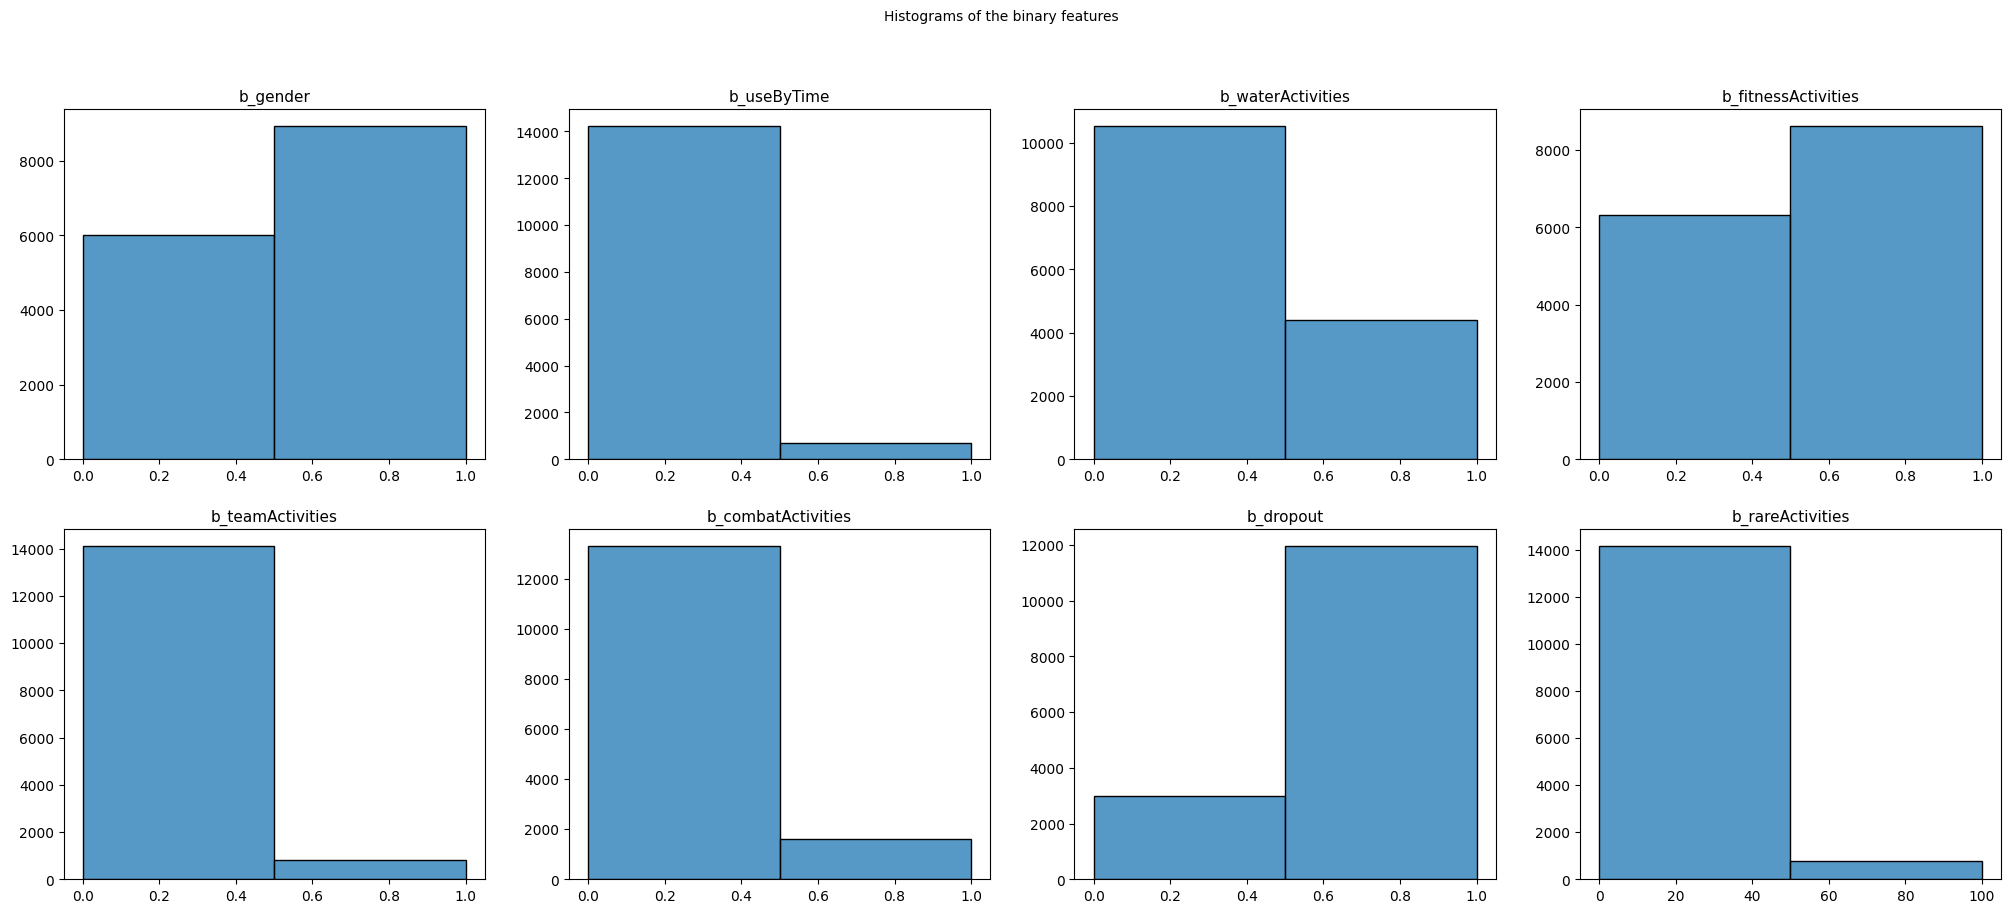

In [ ]:
# Lets plot the distribution of each of the binary features
binary_features = [col for col in data.columns if col.startswith('b_')]
fig, axs = plt.subplots(nrows = 2, ncols=4 , figsize=(25, 10))

for i in range(len(binary_features)):
    sns.histplot(data=data, x=binary_features[i], ax=axs[int(i/4), i%4], bins=2)
    axs[int(i/4), i%4].set_xlabel('')
    axs[int(i/4), i%4].set_ylabel('')
    axs[int(i/4), i%4].set_title(f'{binary_features[i]}', fontsize=11)
fig.suptitle('Histograms of the binary features', fontsize=10)
plt.show()

## __8. Exporting the data__

In [ ]:
to_include_dropped = dropped[['n_age', 'n_renewals', 'n_allowedVisits', 'n_daysWithoutFrequency', 'n_lifetimeValue', 'n_realVisits', 'n_classesWeek', 'n_attendedClasses', 'n_frequencies']]    
to_include_dropped.columns = ['drop_' + col for col in to_include_dropped.columns]

data = pd.concat([data, to_include_dropped], axis=1).dropna()

In [ ]:
data.to_csv('../Datasets/data_cleaned.csv', index=False)